In [41]:
!pip install --quiet kagglehub ipywidgets pandas matplotlib seaborn ultralytics

In [42]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thepbordin/indoor-object-detection")

print("Path to dataset files:", path)

Path to dataset files: /home/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1


In [43]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import torch

# import IPython.display as display
from PIL import Image

from ultralytics import YOLO

In [67]:
class CFG:
    DEBUG = False  # Set to True to make quick experiments
    FRACTION = 0.01 if DEBUG else 1.0
    SEED = 42

    # classes
    CLASSES = [
        'door',
        'cabinetDoor',
        'refrigeratorDoor',
        'window',
        'chair',
        'table',
        'cabinet',
        'couch',
        'openedDoor',
        'pole']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 1 if DEBUG else 70
    BATCH_SIZE = 4 if DEBUG else 8

    BASE_MODEL = 'yolov9e'  # yolov8n, yolov8s, yolov8m, yolov9e, etc.
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'indoor_objects_{EPOCHS}_epochs'

    OPTIMIZER = 'auto'
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    # CUSTOM_DATASET_DIR = '../data/indoor-object-detection/'  # change path as needed
    ROOT_DIR = os.getcwd() + '/Workspace/Jupyter/go-it-dl-nlp/homeworks'
    OUTPUT_DIR = os.path.join(ROOT_DIR, "hw-3")

In [68]:
CFG.CUSTOM_DATASET_DIR = path

In [69]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [70]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- door
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- couch
- openedDoor
- pole
nc: 10
test: /home/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1/test
train: /home/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1/train
val: /home/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1/valid



In [71]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')
    plt.show()

/home/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1/train/images/glass-crystal-drawer-pulls.jpg
Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (750, 1000, 3) 



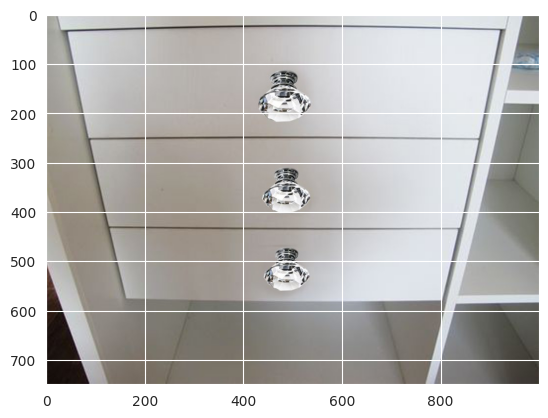

In [72]:
example_image_path = CFG.CUSTOM_DATASET_DIR + '/train/images/glass-crystal-drawer-pulls.jpg'
print(example_image_path)
display_image(example_image_path, print_info = True, hide_axis = False)

In [73]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

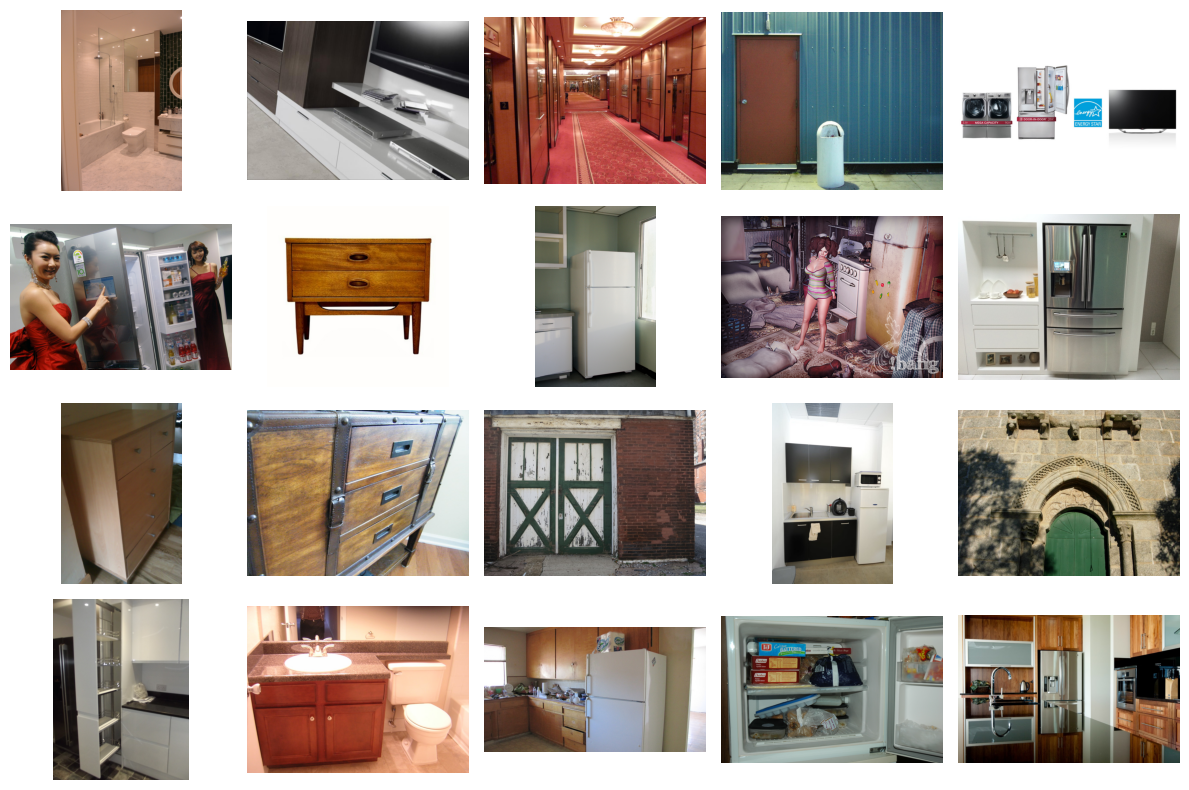

In [74]:
folder_path = CFG.CUSTOM_DATASET_DIR + '/train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

In [75]:
import cv2
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [76]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 1000, 'height': 750, 'channels': 3, 'dtype': dtype('uint8')}

In [77]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    mode_path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(mode_path):
        with open(os.path.join(mode_path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(mode_path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None):
    display(dataset_stats_df)

,Mode,door,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,couch,openedDoor,pole,Data_Volume
0,train,309,448,332,187,105,165,138,22,68,14,1008
1,valid,63,99,85,39,24,30,28,1,13,4,230
2,test,25,42,1,49,38,41,44,31,18,3,104


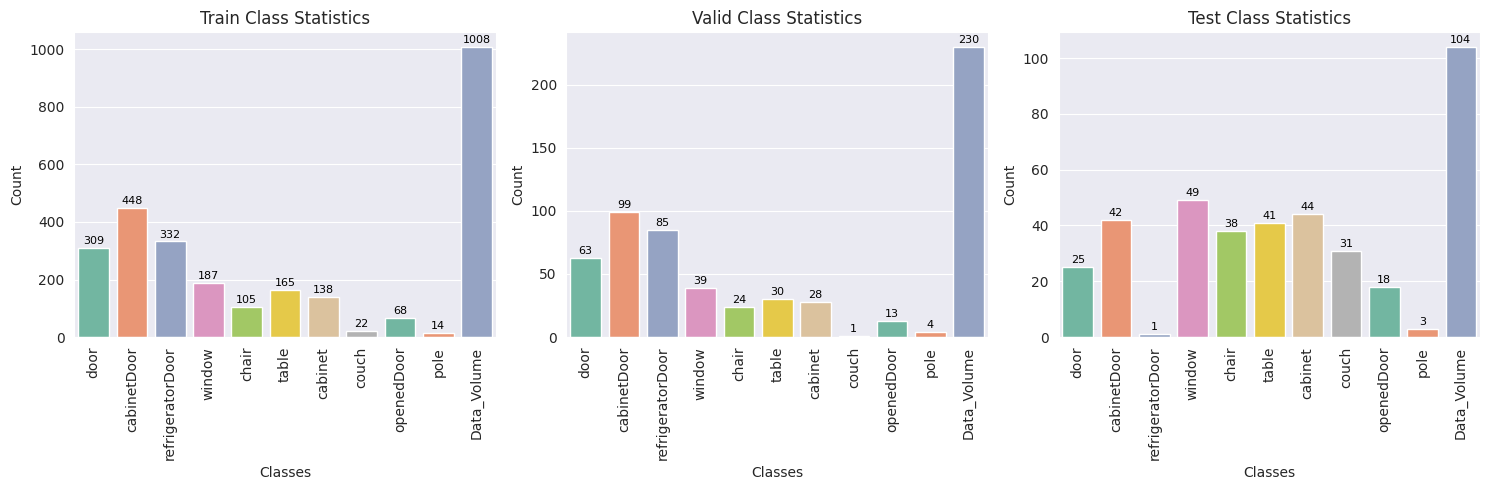

In [78]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

In [79]:
# Визначення пристрою вручну
if torch.cuda.is_available():
    device = "cuda:0"
    print("Using CUDA (NVIDIA GPU)")
elif torch.backends.mps.is_available():
    device = "mps"
    torch.mps.empty_cache() # Чистим кеш перед запуском
    print("Using MPS (Apple Silicon GPU)")
else:
    device = "cpu"
    print("Using CPU")

Using CUDA (NVIDIA GPU)


In [80]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,  # шлях до зображення або np.ndarray
    classes = [0],                # фільтрація лише за класом "door" (0-й індекс)
    conf = 0.50,                  # поріг впевненості детекції
    device = device,               # CPU (можна: 0 для GPU, [0,1] для мульти-GPU)
    imgsz = (img_properties['height'], img_properties['width']),  # розмір вхідного зображення
    project=CFG.OUTPUT_DIR,
    name="predictions",
    save = True,                  # зберігати результати як зображення з bbox
    save_txt = True,              # зберігати YOLO-формат у .txt
    save_conf = True,             # зберігати значення впевненості у .txt
    exist_ok = True,              # не створювати нову папку якщо вже існує
)


WARNING ⚠️ imgsz=[750, 1000] must be multiple of max stride 32, updating to [768, 1024]
image 1/1 /home/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1/train/images/glass-crystal-drawer-pulls.jpg: 768x1024 (no detections), 29.5ms
Speed: 2.0ms preprocess, 29.5ms inference, 0.4ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to /home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/predictions
0 label saved to /home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/predictions/labels


In [81]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  70
Batch:  8


In [93]:
model = YOLO('yolov9e.yaml')

# Показати всю архітектуру
# print(model.model)
for i, m in enumerate(model.model.model):
    print(f"{i}: {m.__class__.__name__}")

0: Identity
1: Conv
2: Conv
3: RepNCSPELAN4
4: ADown
5: RepNCSPELAN4
6: ADown
7: RepNCSPELAN4
8: ADown
9: RepNCSPELAN4
10: CBLinear
11: CBLinear
12: CBLinear
13: CBLinear
14: CBLinear
15: Conv
16: CBFuse
17: Conv
18: CBFuse
19: RepNCSPELAN4
20: ADown
21: CBFuse
22: RepNCSPELAN4
23: ADown
24: CBFuse
25: RepNCSPELAN4
26: ADown
27: CBFuse
28: RepNCSPELAN4
29: SPPELAN
30: Upsample
31: Concat
32: RepNCSPELAN4
33: Upsample
34: Concat
35: RepNCSPELAN4
36: ADown
37: Concat
38: RepNCSPELAN4
39: ADown
40: Concat
41: RepNCSPELAN4
42: Detect


In [101]:
### train
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    imgsz = 640,
    # imgsz = (img_properties['height'], img_properties['width']),
    pretrained=CFG.BASE_MODEL_WEIGHTS,
    epochs = CFG.EPOCHS,
    batch = 10, #CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,

    project=CFG.OUTPUT_DIR,
    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    amp = True,
    exist_ok = True,
    resume = False,
    device = device, #  [0,1]
    verbose = False,

    # Додамо аугментацію
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.2,
    copy_paste=0.1,
    freeze=10, # Можливо
)

New https://pypi.org/project/ultralytics/8.3.138 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.137 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3090, 24135MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov9e.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=

train: Scanning /home/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1/train/labels.cache... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1357.2±207.4 MB/s, size: 339.8 KB)


val: Scanning /home/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1/valid/labels.cache... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<?, ?it/s]


Plotting labels to /home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.00046875), 309 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      9.61G      1.263      1.154      1.387         49        640: 100%|██████████| 102/102 [00:27<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.47it/s]

                   all        230       1289      0.426      0.457      0.424      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      11.3G      1.254      1.136      1.362         28        640: 100%|██████████| 102/102 [00:27<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]

                   all        230       1289      0.393      0.427      0.385      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      11.4G       1.29       1.18      1.386         34        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.454      0.397      0.406      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      11.4G      1.295      1.235       1.42         22        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.423      0.401      0.383      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      11.4G        1.3       1.22      1.409         46        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289        0.5      0.374      0.394      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      11.4G      1.288      1.209        1.4         11        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.532      0.455       0.47      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      11.4G      1.274      1.146      1.376         40        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]

                   all        230       1289       0.35      0.467      0.396      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      11.4G      1.259      1.139      1.375          4        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.41it/s]

                   all        230       1289      0.413      0.507       0.42      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      11.4G      1.256      1.141      1.367         33        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]

                   all        230       1289      0.498      0.369      0.401      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      11.4G      1.266      1.135      1.383         19        640: 100%|██████████| 102/102 [00:27<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289       0.39      0.405      0.398      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      11.4G      1.257       1.12       1.37          6        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.41it/s]

                   all        230       1289       0.39      0.432      0.402      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      11.4G      1.231       1.06      1.348         29        640: 100%|██████████| 102/102 [00:26<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.504      0.506      0.504      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      11.4G      1.196      1.051      1.337         21        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.422      0.495      0.413      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      11.4G      1.214      1.054      1.355          7        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]

                   all        230       1289      0.451      0.438      0.398      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      11.4G      1.191      1.022       1.33         31        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]

                   all        230       1289      0.401      0.448      0.408      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      11.4G      1.162     0.9961      1.319         10        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.392      0.416      0.399      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      11.4G      1.166     0.9664      1.309         14        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]

                   all        230       1289      0.429      0.345      0.397      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      11.4G      1.173      1.018      1.328         34        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.517      0.381      0.407       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      11.4G       1.17     0.9574      1.303         20        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.445      0.447      0.415       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      11.4G      1.154     0.9671      1.307         19        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.475      0.468      0.412      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      11.4G      1.134     0.9336      1.295         62        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.531       0.48      0.483      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      11.4G       1.15     0.9433      1.294         45        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.589      0.396      0.406      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      11.4G      1.119     0.9427      1.281         23        640: 100%|██████████| 102/102 [00:26<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.384      0.452      0.422      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      11.4G      1.117     0.9327      1.285         14        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289       0.44      0.461      0.456      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      11.4G      1.112     0.9047      1.278          6        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289       0.39      0.561      0.433      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      11.4G      1.122     0.9128      1.277         24        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.476      0.434       0.45      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      11.4G      1.106     0.8917      1.262         14        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.41it/s]

                   all        230       1289      0.501      0.378      0.421      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      11.4G      1.105      0.916      1.275         17        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.511       0.38      0.398      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      11.4G      1.094     0.8888      1.258          5        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.397       0.46      0.425      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      11.4G      1.078     0.8639      1.258         21        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]

                   all        230       1289      0.446      0.396      0.399      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      11.4G      1.084     0.8673      1.257         12        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.378      0.531      0.418      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      11.4G      1.051      0.829      1.236         18        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.449      0.514      0.502      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      11.4G      1.084     0.8885      1.258          9        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]

                   all        230       1289      0.437      0.497      0.419      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      11.4G      1.077     0.8661      1.255         41        640: 100%|██████████| 102/102 [00:26<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.404      0.543      0.423      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      11.4G      1.044     0.8233      1.234          7        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.612      0.457      0.446      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      11.4G      1.057     0.8509      1.262         13        640: 100%|██████████| 102/102 [00:26<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.415      0.528      0.413      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      11.4G      1.029     0.8131      1.228         22        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.437      0.422      0.416       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      11.4G      1.029     0.8192      1.238         13        640: 100%|██████████| 102/102 [00:26<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]

                   all        230       1289      0.415      0.556      0.452       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      11.4G      1.018     0.7949      1.217         17        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.562      0.454      0.425      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      11.4G     0.9955     0.7804      1.199          9        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.345       0.46      0.407      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      11.4G      1.017     0.7902      1.222          7        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]

                   all        230       1289      0.382      0.472      0.402      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      11.4G     0.9874     0.7746      1.209         10        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.446      0.382      0.405      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      11.4G      1.011     0.8023      1.226          4        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.608      0.489      0.471      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      11.4G     0.9743     0.7446      1.194         24        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.608      0.443      0.452      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      11.4G     0.9608     0.7395      1.187         17        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]

                   all        230       1289      0.388      0.485       0.41      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      11.4G      0.951     0.7285      1.173         20        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]

                   all        230       1289      0.551      0.489      0.426      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      11.4G     0.9527     0.7354      1.178         30        640: 100%|██████████| 102/102 [00:26<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.457       0.47      0.497      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      11.4G     0.9668      0.745      1.191         27        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]

                   all        230       1289      0.474      0.504      0.467      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      11.4G     0.9426     0.7297      1.185         11        640: 100%|██████████| 102/102 [00:26<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]

                   all        230       1289      0.483      0.465      0.431      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      11.4G     0.9402     0.7133      1.175         15        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.675      0.409      0.454      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      11.4G     0.9468     0.7178      1.184         13        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.443      0.416      0.415      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      11.4G     0.9295     0.6954      1.162         50        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]

                   all        230       1289      0.414      0.472      0.425      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      11.4G     0.9308     0.7096      1.178         38        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.472      0.514      0.427       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      11.4G     0.9099     0.6969      1.168         21        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.47it/s]

                   all        230       1289      0.608      0.463      0.514      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      11.4G     0.8973     0.6763      1.145         27        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.507      0.502      0.473      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      11.4G     0.9078     0.6756      1.153         15        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]

                   all        230       1289      0.542      0.483      0.433      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      11.4G     0.8959     0.6793      1.148         24        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.483       0.52      0.468      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      11.4G     0.8742     0.6367      1.131         12        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]

                   all        230       1289      0.522      0.468      0.462      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      11.4G     0.8779      0.667       1.14         17        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        230       1289      0.484      0.512      0.475      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      11.4G     0.8732     0.6489      1.131         24        640: 100%|██████████| 102/102 [00:26<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.603      0.452      0.462      0.266


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      11.4G     0.7052     0.4217       1.01          3        640: 100%|██████████| 102/102 [00:26<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]

                   all        230       1289       0.61      0.424      0.431      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      11.4G     0.7001     0.3789      1.014         10        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]

                   all        230       1289      0.544      0.478      0.415      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      11.4G     0.6752     0.3652      1.002         18        640: 100%|██████████| 102/102 [00:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.447      0.512      0.432      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      11.4G     0.6692     0.3545     0.9973          2        640: 100%|██████████| 102/102 [00:26<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.47it/s]

                   all        230       1289      0.577      0.443      0.415      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      11.4G     0.6805     0.3633      1.001          7        640: 100%|██████████| 102/102 [00:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]

                   all        230       1289      0.559       0.45       0.44      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      11.4G     0.6502     0.3449     0.9878          5        640: 100%|██████████| 102/102 [00:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]

                   all        230       1289        0.6      0.433      0.422       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      11.4G     0.6359     0.3485     0.9809          7        640: 100%|██████████| 102/102 [00:26<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        230       1289      0.565      0.476      0.447      0.258
EarlyStopping: Training stopped early as no improvement observed in last 35 epochs. Best results observed at epoch 32, best model saved as best.pt.
To update EarlyStopping(patience=35) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



67 epochs completed in 0.557 hours.
Optimizer stripped from /home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/weights/last.pt, 117.3MB
Optimizer stripped from /home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/weights/best.pt, 117.3MB

Validating /home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3090, 24135MiB)
YOLOv9e summary (fused): 279 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.63it/s]


                   all        230       1289      0.451      0.514      0.502      0.294
Speed: 0.1ms preprocess, 7.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b794b53b1c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [103]:
# Export the model
# The 'fraction' argument is not supported for ONNX export.
# It might be present in model.overrides from previous settings (e.g., INT8 calibration).
# We temporarily remove it to prevent the AssertionError.
_fraction_backup = None
if hasattr(model, 'overrides') and isinstance(model.overrides, dict) and 'fraction' in model.overrides:
    print("Note: Temporarily removing 'fraction' from model.overrides for ONNX export.")
    _fraction_backup = model.overrides.pop('fraction')

model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = 640,
    # imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
    project=CFG.OUTPUT_DIR,
    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
)

Note: Temporarily removing 'fraction' from model.overrides for ONNX export.
Ultralytics 8.3.137 🚀 Python-3.10.16 torch-2.6.0+cu124 CPU (AMD Ryzen 9 7900X3D 12-Core Processor)
YOLOv9e summary (fused): 279 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from '/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (111.8 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 2.1s, saved as '/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/weights/best.onnx' (219.3 MB)

Export complete (3.5s)
Results saved to /home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/weights
Predict:         yolo predict task=detect model=/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/weights/best.onnx imgsz

'/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/weights/best.onnx'

In [104]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/P_curve.png',
 '/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/PR_curve.png',
 '/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/R_curve.png',
 '/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/results.png',
 '/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/confusion_matrix_normalized.png',
 '/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/F1_curve.png',
 '/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/confusion_matrix.png',
 '/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/labels.jpg',
 '/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/lab

/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/F1_curve.png


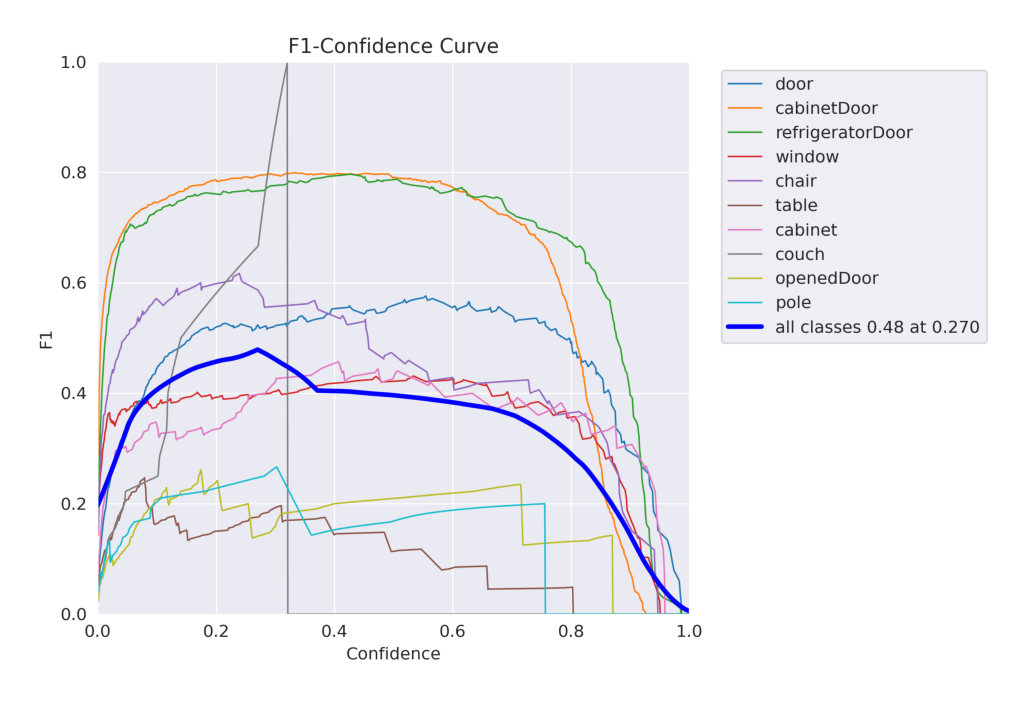



/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/PR_curve.png


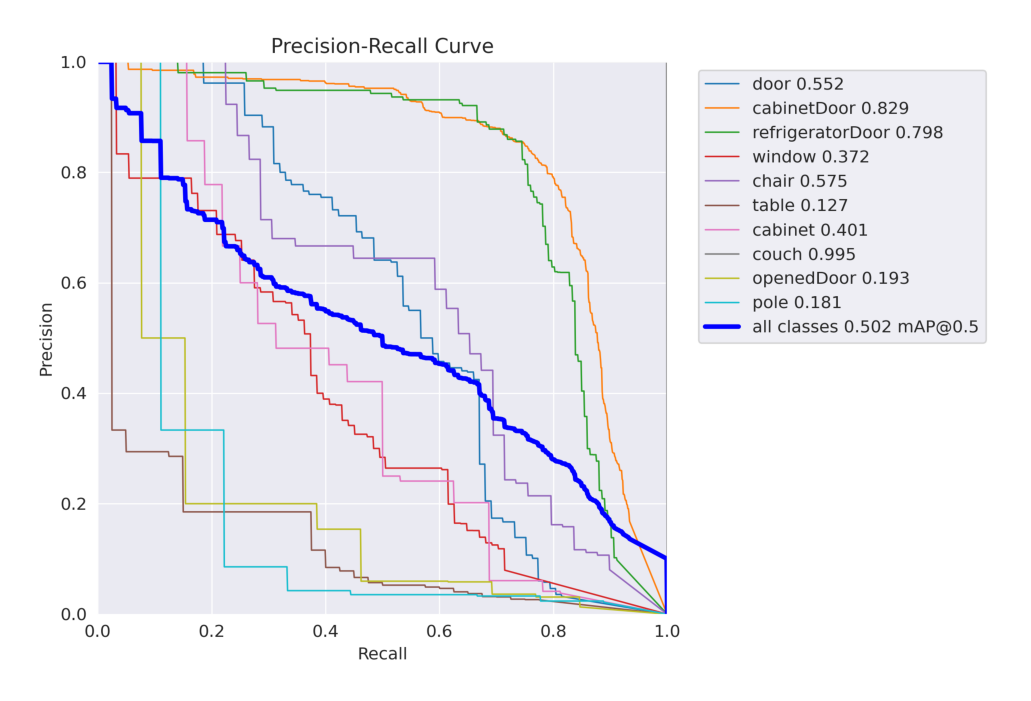



/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/P_curve.png


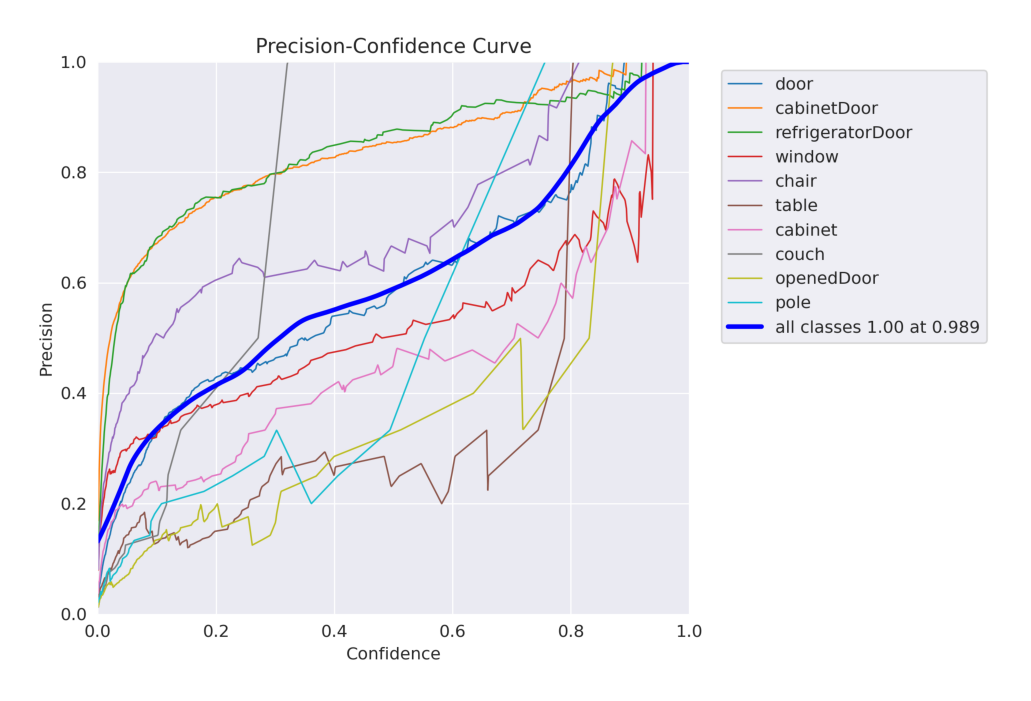



/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/R_curve.png


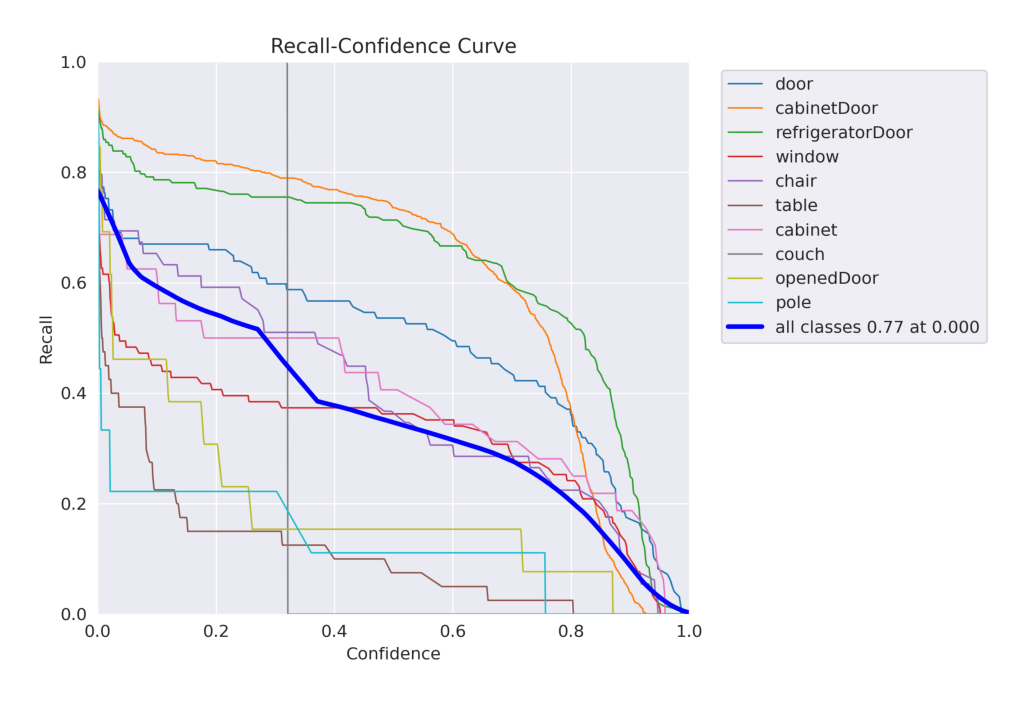



/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/confusion_matrix.png


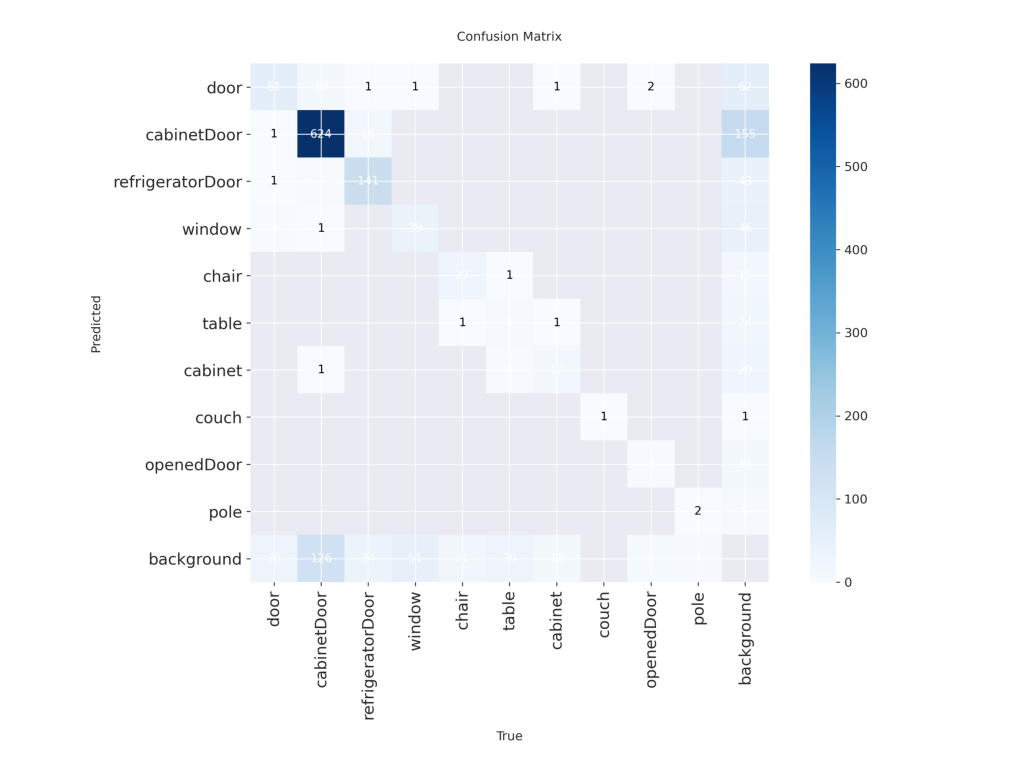



/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/confusion_matrix_normalized.png


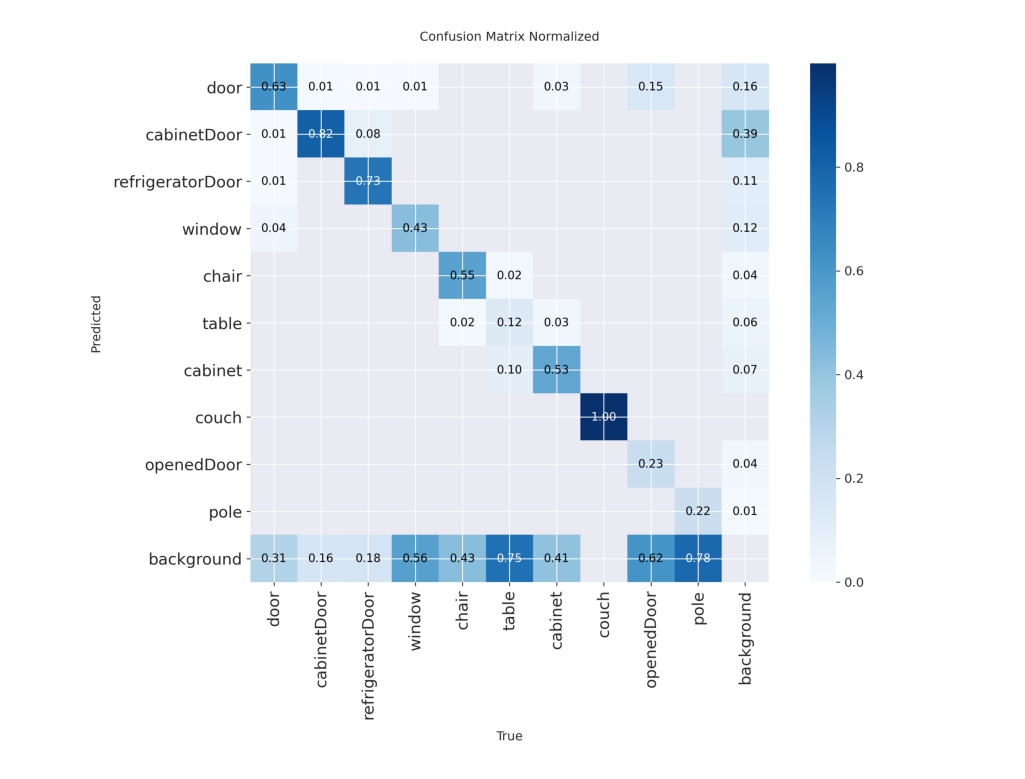



/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/labels.jpg


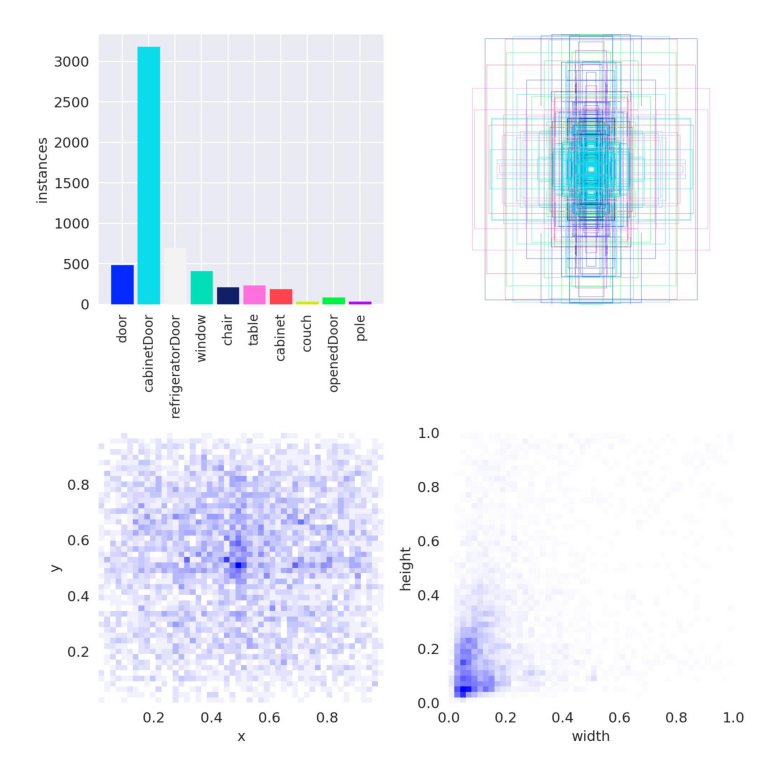



/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/labels_correlogram.jpg


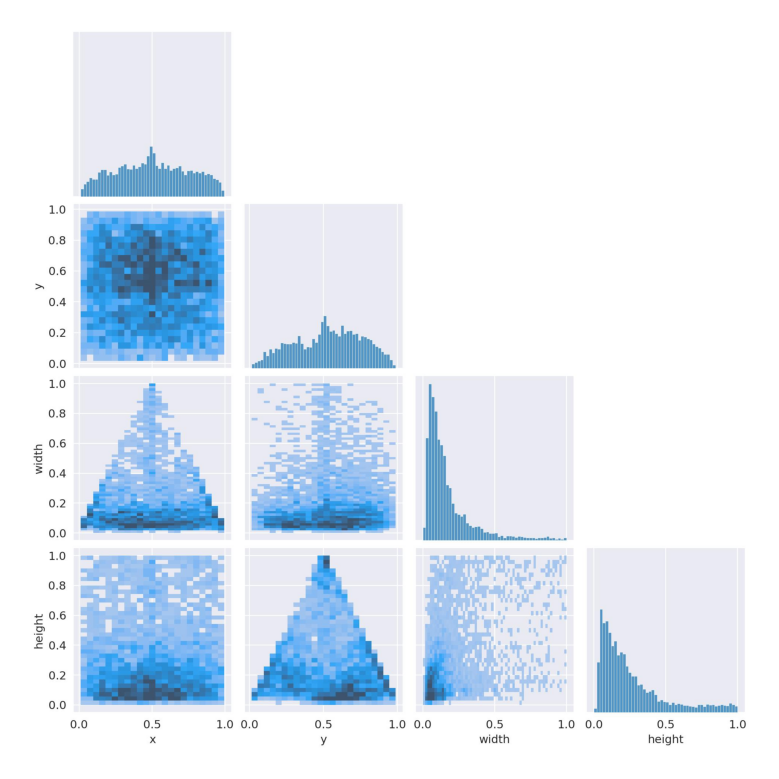



/home/vdubyna/Workspace/Jupyter/go-it-dl-nlp/homeworks/hw-3/yolov9e_indoor_objects_70_epochs/results.png


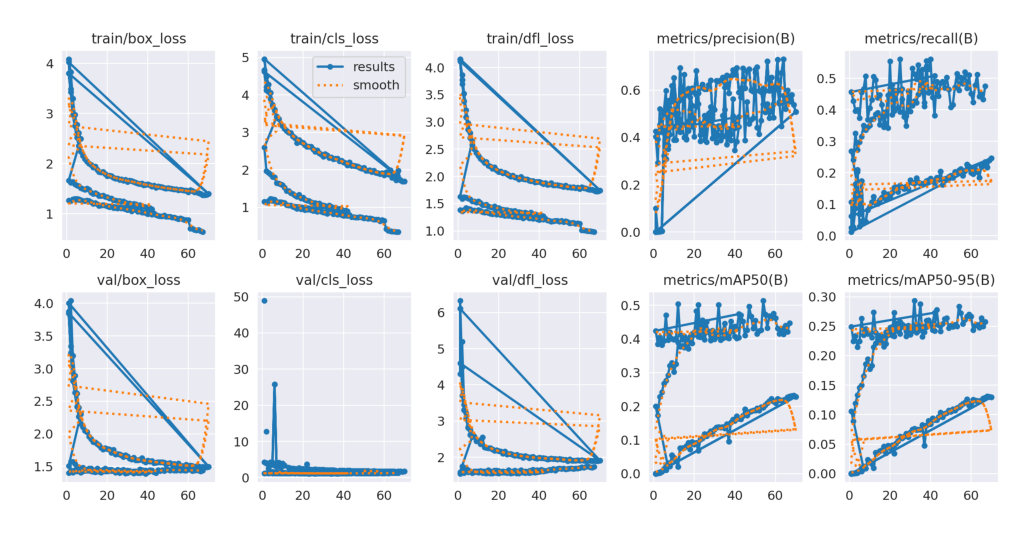

In [105]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

## Результати мого дослідження

### Що я робив під час експерименту?

Щоб модель краще працювала і швидше навчалася, я вніс кілька змін:

1.  **"Заморозив" частину моделі YOLO:** Перші 10 шарів моделі були зафіксовані. Це допомогло моделі швидше вчитися розпізнавати об'єкти, використовуючи вже наявні знання про прості речі (лінії, кути).
2.  **Зменшив розмір картинок:** Спочатку картинки були великі, і навчання йшло довго. Я зменшив їх до розміру 640x640, що значно прискорило процес.
3.  **Додав аугментацію:** Модель швидко "запам'ятовувала" тренувальні картинки. Щоб це виправити, я додав трансформацію картинок.

### Що показали графіки навчання?

* Графіки показують, що помилки моделі на тренувальних даних зменшувалися, а важливі показники якості (як-от mAP50) зростали. Це означає, що процес навчання працює добре.
* Наприкінці навчання помилки на нових (валідаційних) даних перестали зменшуватися або навіть трохи зросли, хоча на тренувальних даних все ще падали. Це ознака того, що модель почала занадто сильно підлаштовуватися під тренувальні приклади.

### Як модель розпізнає різні об'єкти?

* **Загалом непогано:** Середній показник якості (mAP@0.5) склав близько 0.5, що є прийнятним результатом для початку.
* **Є лідери і аутсайдери:**
    * Такі об'єкти, як `cabinetDoor` (дверцята шафи), `refrigeratorDoor` (дверцята холодильника) та `couch` (диван), модель розпізнає досить добре.
    * А ось з такими об'єктами, як `table` (стіл), `openedDoor` (відчинені двері) та `pole` (стовп), виникли проблеми – модель їх часто плутає або не бачить.
* **Кількість прикладів важлива:** Класи, для яких було багато картинок (`cabinetDoor`), розпізнаються краще. Де картинок мало (`pole`, `openedDoor`), там і результати гірші.

### Які помилки робить модель?

* **Плутає схожі речі:** Наприклад, `door` (двері) іноді плутаються з `cabinetDoor` (дверцята шафи) або `openedDoor` (відчинені двері).
* **"Не бачить" деякі об'єкти на фоні:** Об'єкти типу `window` (вікно), `table` (стіл) і особливо `pole` (стовп) модель часто приймає за фон.

### Загальні висновки та що робити далі

* **Перенавчання:** Модель все ще схильна до перенавчання, потрібно продовжувати з цим боротися.
* **Розпізнавання складних класів:** Деякі об'єкти модель бачить погано, особливо ті, яких мало в даних або які легко сплутати з фоном.
* **Баланс даних:** Нерівна кількість прикладів для різних класів заважає.

Загалом, експеримент показав, що обраний підхід працює, але для досягнення дійсно високих результатів по всім класам об'єктів потрібна подальша робота.